# <p style="text-align: center;"><font color='blue'> Python Workshop (Machine Learning) </font> <br> <font color='maroon'> Chicago Booth </font> <br> November 18th</p>

### <font color = 'blue'>Scikit-learn</font> is the main machine learning package for Python. <br><font color='blue'>Pandas</font> is the main data analysis library. <br> <font color='blue'>Numpy</font> is the main scientific computing package. <br> <font color='blue'>Matplotlib</font> allows for creation of simple plots. <br> <font color='blue'>Seaborn</font> is built on top of matplotlib and allows for more complex visualizations.

<hr>

### For further reading, two of my favorite, free machine learning books (unfortunately, the examples are in R...):

http://www-bcf.usc.edu/~gareth/ISL/
https://web.stanford.edu/~hastie/ElemStatLearn/

In [113]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn is a gigantic package, so it's better to import specific modules,
# although some people advise against using 'from' since it overrides namespaces
from sklearn import model_selection, preprocessing
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

We will be using one of the datasets from the recent [2017 Kaggle Data Science Survey](https://www.kaggle.com/kaggle/kaggle-survey-2017). A summary of the survey: <br> <br> "For the first time, Kaggle conducted an industry-wide survey to establish a comprehensive view of the state of data science and machine learning. The survey received over 16,000 responses and we learned a ton about who is working with data, what’s happening at the cutting edge of machine learning across industries, and how new data scientists can best break into the field."

In [114]:
df = pd.read_csv('multipleChoiceResponses.csv', encoding="ISO-8859-1", low_memory=False,
                thousands = ',')
schema = pd.read_csv('schema.csv')

In [115]:
pd.set_option('display.max_columns', None)
df.head(5)

,GenderSelect,Country,Age,EmploymentStatus,StudentStatus,LearningDataScience,CodeWriter,CareerSwitcher,CurrentJobTitleSelect,TitleFit,CurrentEmployerType,MLToolNextYearSelect,MLMethodNextYearSelect,LanguageRecommendationSelect,PublicDatasetsSelect,LearningPlatformSelect,LearningPlatformUsefulnessArxiv,LearningPlatformUsefulnessBlogs,LearningPlatformUsefulnessCollege,LearningPlatformUsefulnessCompany,LearningPlatformUsefulnessConferences,LearningPlatformUsefulnessFriends,LearningPlatformUsefulnessKaggle,LearningPlatformUsefulnessNewsletters,LearningPlatformUsefulnessCommunities,LearningPlatformUsefulnessDocumentation,LearningPlatformUsefulnessCourses,LearningPlatformUsefulnessProjects,LearningPlatformUsefulnessPodcasts,LearningPlatformUsefulnessSO,LearningPlatformUsefulnessTextbook,LearningPlatformUsefulnessTradeBook,LearningPlatformUsefulnessTutoring,LearningPlatformUsefulnessYouTube,BlogsPodcastsNewslettersSelect,LearningDataScienceTime,JobSkillImportanceBigData,JobSkillImportanceDegree,JobSkillImportanceStats,JobSkillImportanceEnterpriseTools,JobSkillImportancePython,JobSkillImportanceR,JobSkillImportanceSQL,JobSkillImportanceKaggleRanking,JobSkillImportanceMOOC,JobSkillImportanceVisualizations,JobSkillImportanceOtherSelect1,JobSkillImportanceOtherSelect2,JobSkillImportanceOtherSelect3,CoursePlatformSelect,HardwarePersonalProjectsSelect,TimeSpentStudying,ProveKnowledgeSelect,DataScienceIdentitySelect,FormalEducation,MajorSelect,Tenure,PastJobTitlesSelect,FirstTrainingSelect,LearningCategorySelftTaught,LearningCategoryOnlineCourses,LearningCategoryWork,LearningCategoryUniversity,LearningCategoryKaggle,LearningCategoryOther,MLSkillsSelect,MLTechniquesSelect,ParentsEducation,EmployerIndustry,EmployerSize,EmployerSizeChange,EmployerMLTime,EmployerSearchMethod,UniversityImportance,JobFunctionSelect,WorkHardwareSelect,WorkDataTypeSelect,WorkProductionFrequency,WorkDatasetSize,WorkAlgorithmsSelect,WorkToolsSelect,WorkToolsFrequencyAmazonML,WorkToolsFrequencyAWS,WorkToolsFrequencyAngoss,WorkToolsFrequencyC,WorkToolsFrequencyCloudera,WorkToolsFrequencyDataRobot,WorkToolsFrequencyFlume,WorkToolsFrequencyGCP,WorkToolsFrequencyHadoop,WorkToolsFrequencyIBMCognos,WorkToolsFrequencyIBMSPSSModeler,WorkToolsFrequencyIBMSPSSStatistics,WorkToolsFrequencyIBMWatson,WorkToolsFrequencyImpala,WorkToolsFrequencyJava,WorkToolsFrequencyJulia,WorkToolsFrequencyJupyter,WorkToolsFrequencyKNIMECommercial,WorkToolsFrequencyKNIMEFree,WorkToolsFrequencyMathematica,WorkToolsFrequencyMATLAB,WorkToolsFrequencyAzure,WorkToolsFrequencyExcel,WorkToolsFrequencyMicrosoftRServer,WorkToolsFrequencyMicrosoftSQL,WorkToolsFrequencyMinitab,WorkToolsFrequencyNoSQL,WorkToolsFrequencyOracle,WorkToolsFrequencyOrange,WorkToolsFrequencyPerl,WorkToolsFrequencyPython,WorkToolsFrequencyQlik,WorkToolsFrequencyR,WorkToolsFrequencyRapidMinerCommercial,WorkToolsFrequencyRapidMinerFree,WorkToolsFrequencySalfrod,WorkToolsFrequencySAPBusinessObjects,WorkToolsFrequencySASBase,WorkToolsFrequencySASEnterprise,WorkToolsFrequencySASJMP,WorkToolsFrequencySpark,WorkToolsFrequencySQL,WorkToolsFrequencyStan,WorkToolsFrequencyStatistica,WorkToolsFrequencyTableau,WorkToolsFrequencyTensorFlow,WorkToolsFrequencyTIBCO,WorkToolsFrequencyUnix,WorkToolsFrequencySelect1,WorkToolsFrequencySelect2,WorkFrequencySelect3,WorkMethodsSelect,WorkMethodsFrequencyA/B,WorkMethodsFrequencyAssociationRules,WorkMethodsFrequencyBayesian,WorkMethodsFrequencyCNNs,WorkMethodsFrequencyCollaborativeFiltering,WorkMethodsFrequencyCross-Validation,WorkMethodsFrequencyDataVisualization,WorkMethodsFrequencyDecisionTrees,WorkMethodsFrequencyEnsembleMethods,WorkMethodsFrequencyEvolutionaryApproaches,WorkMethodsFrequencyGANs,WorkMethodsFrequencyGBM,WorkMethodsFrequencyHMMs,WorkMethodsFrequencyKNN,WorkMethodsFrequencyLiftAnalysis,WorkMethodsFrequencyLogisticRegression,WorkMethodsFrequencyMLN,WorkMethodsFrequencyNaiveBayes,WorkMethodsFrequencyNLP,WorkMethodsFrequencyNeuralNetworks,WorkMethodsFrequencyPCA,WorkMethodsFrequencyPrescripti

### We'll be applying machine learning techniques to predict and understand two different variables: 

### 1) Job satisfaction <br> 2) Total compensation (salary + bonus)

In [116]:
# Filter out non-US and un/under-employed

df_us = df[(df.Country == 'United States') &
                 (df.Age > 21) &
                 (df.Age <= 65) &
                 (df.EmploymentStatus == 'Employed full-time') &
                 (df.JobSatisfaction != 'I prefer not to share') &
                 (df.JobSatisfaction.notnull())]

len(df_us)

1592

In [117]:
pd.set_option('chained_assignment',None)

#Clean up compensation data
df_clean = df_us
df_clean['CompensationAmount'] = df_us['CompensationAmount'].astype(str).str.replace(',','')
df_clean = df_clean[(df_clean['CompensationAmount'] != 'nan')]
df_clean['CompensationAmount'] = df_clean['CompensationAmount'].astype(float)
df_clean = df_clean[(df_clean['CompensationAmount'] > 25000) &
                                        (df_clean['CompensationAmount'] < 1000000)]

In [118]:
# Dropna parameter will include null counts
df_clean['JobSatisfaction'].value_counts(dropna = False)

7                          285
8                          282
9                          188
6                          129
10 - Highly Satisfied      121
5                          109
3                           71
4                           66
1 - Highly Dissatisfied     35
2                           18
Name: JobSatisfaction, dtype: int64

In [119]:
# Add a new categorical variable 'JobSatisfactionLabel' that turns the numerical job satisfaction level into categories

df_clean['JobSatisfaction'] = df_clean['JobSatisfaction'].str[:2].astype(int)
df_clean['JobSatisfactionLabel'] = pd.qcut(x = df_clean['JobSatisfaction'], q = [0, .3, .6, 1] , 
                                           labels = ['0', '1', '2'])


In [120]:
#Check to make sure labels look right

df_clean['JobSatisfactionLabel'].value_counts()

1    567
0    428
2    309
Name: JobSatisfactionLabel, dtype: int64

In [121]:
df_clean = df_clean.dropna(axis = 1, thresh = len(df_clean) * .8)
df_clean.columns

Index(['GenderSelect', 'Country', 'Age', 'EmploymentStatus', 'CodeWriter',
       'CurrentJobTitleSelect', 'TitleFit', 'CurrentEmployerType',
       'MLToolNextYearSelect', 'MLMethodNextYearSelect',
       'LanguageRecommendationSelect', 'PublicDatasetsSelect',
       'LearningPlatformSelect', 'FormalEducation', 'MajorSelect', 'Tenure',
       'PastJobTitlesSelect', 'FirstTrainingSelect',
       'LearningCategorySelftTaught', 'LearningCategoryOnlineCourses',
       'LearningCategoryWork', 'LearningCategoryUniversity',
       'LearningCategoryKaggle', 'LearningCategoryOther', 'MLSkillsSelect',
       'MLTechniquesSelect', 'ParentsEducation', 'EmployerIndustry',
       'EmployerSize', 'EmployerSizeChange', 'EmployerMLTime',
       'EmployerSearchMethod', 'UniversityImportance', 'JobFunctionSelect',
       'WorkHardwareSelect', 'WorkDataTypeSelect', 'WorkProductionFrequency',
       'WorkDatasetSize', 'WorkAlgorithmsSelect', 'WorkToolsSelect',
       'WorkMethodsSelect', 'TimeGatheringDat

In [11]:
# Let's look at how many unique values each variable has --
# one important thing to do before modeling is to drop or trim down any categorical
# variables with too many levels

df_clean.apply(lambda x: len(x.unique()))

GenderSelect                        5
Country                             1
Age                                44
EmploymentStatus                    1
CodeWriter                          1
CurrentJobTitleSelect              16
TitleFit                            4
CurrentEmployerType                33
MLToolNextYearSelect               44
MLMethodNextYearSelect             26
LanguageRecommendationSelect       13
PublicDatasetsSelect               86
LearningPlatformSelect           1066
FormalEducation                     8
MajorSelect                        15
Tenure                              7
PastJobTitlesSelect               381
FirstTrainingSelect                 6
LearningCategorySelftTaught        39
LearningCategoryOnlineCourses      28
LearningCategoryWork               34
LearningCategoryUniversity         37
LearningCategoryKaggle             21
LearningCategoryOther              22
MLSkillsSelect                    275
MLTechniquesSelect                446
ParentsEduca

In [12]:
df_clean['MLTechniquesSelect']

22       Decision Trees - Random Forests,Gradient Boost...
34       Bayesian Techniques,Decision Trees - Random Fo...
75       Bayesian Techniques,Decision Trees - Gradient ...
80       Bayesian Techniques,Decision Trees - Gradient ...
86       Decision Trees - Random Forests,Ensemble Metho...
89       Bayesian Techniques,Decision Trees - Random Fo...
100      Decision Trees - Gradient Boosted Machines,Dec...
106      Decision Trees - Gradient Boosted Machines,Dec...
133                Bayesian Techniques,Logistic Regression
163                                                    NaN
178                                    Logistic Regression
187      Decision Trees - Random Forests,Logistic Regre...
194      Decision Trees - Gradient Boosted Machines,Dec...
197      Decision Trees - Gradient Boosted Machines,Dec...
203      Decision Trees - Gradient Boosted Machines,Dec...
258      Bayesian Techniques,Decision Trees - Random Fo...
265         Other (please specify; separate by semi-colo

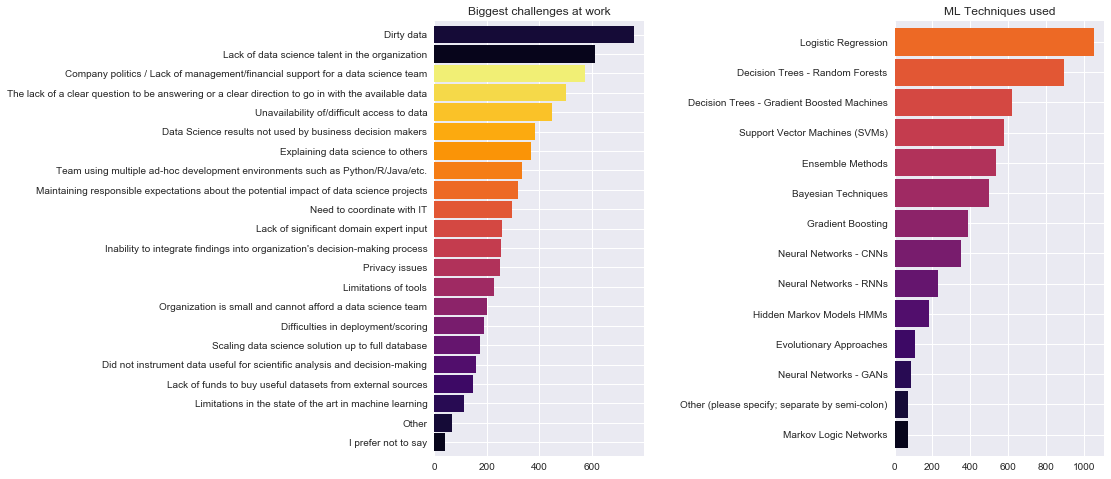

In [13]:
# Still might be interesting to look at some of these

plt.clf()
f,ax = plt.subplots(1,2,figsize=(12,8))
work = df_clean['WorkChallengesSelect'].str.split(',')
work_set = []
for i in work.dropna():
    work_set.extend(i)
pd.Series(work_set).value_counts().sort_values(ascending=True).plot.barh(width=0.9,color=sns.color_palette('inferno',20),ax=ax[0])
ax[0].set_title('Biggest challenges at work')
mltech = df_clean['MLTechniquesSelect'].str.split(',')
techniques=[]
for i in mltech.dropna():
    techniques.extend(i)
pd.Series(techniques).value_counts().sort_values(ascending=True).plot.barh(width=0.9,color=sns.color_palette('inferno',20),ax=ax[1])
ax[1].set_title('ML Techniques used')
plt.subplots_adjust(wspace=1.2)
plt.show()

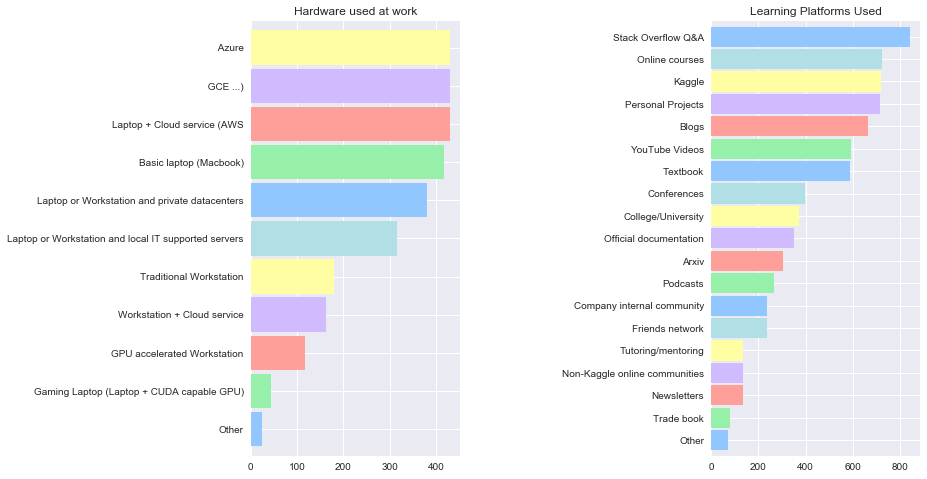

In [14]:
# Still might be interesting to look at even more of these
# This palette is kind of ugly though

plt.clf()
f,ax = plt.subplots(1,2,figsize=(12,8))
hard = df_clean['WorkHardwareSelect'].str.split(',')
hard_set = []
for i in hard.dropna():
    hard_set.extend(i)
pd.Series(hard_set).value_counts().sort_values(ascending=True).plot.barh(width=0.9,color=sns.color_palette('pastel',20),ax=ax[0])
ax[0].set_title('Hardware used at work')
learning = df_clean['LearningPlatformSelect'].str.split(',')
learning_set =[]
for i in learning.dropna():
    learning_set.extend(i)
pd.Series(learning_set).value_counts().sort_values(ascending=True).plot.barh(width=0.9,color=sns.color_palette('pastel',20),ax=ax[1])
ax[1].set_title('Learning Platforms Used')
plt.subplots_adjust(wspace=1.2)
plt.show()

In [122]:
selected_col = ['GenderSelect','Age',
       'CurrentJobTitleSelect', 'TitleFit', 'CurrentEmployerType',
       'LanguageRecommendationSelect', 'PublicDatasetsSelect',
       'FormalEducation', 'MajorSelect', 'Tenure',
       'PastJobTitlesSelect', 'FirstTrainingSelect',
       'LearningCategorySelftTaught', 'LearningCategoryOnlineCourses',
       'LearningCategoryWork', 'LearningCategoryUniversity',
       'LearningCategoryKaggle', 'LearningCategoryOther', 'ParentsEducation', 'EmployerIndustry',
       'EmployerSize', 'EmployerSizeChange', 'EmployerMLTime',
       'EmployerSearchMethod', 'UniversityImportance', 'JobFunctionSelect',
        'WorkDataTypeSelect', 'WorkProductionFrequency',
       'WorkDatasetSize',
       'TimeGatheringData', 'TimeModelBuilding',
       'TimeProduction', 'TimeVisualizing', 'TimeFindingInsights',
       'TimeOtherSelect', 'AlgorithmUnderstandingLevel',
       'WorkDataVisualizations',
       'WorkInternalVsExternalTools', 'WorkMLTeamSeatSelect',
       'WorkDataStorage', 'WorkDataSharing', 'WorkCodeSharing', 'RemoteWork',
       'CompensationAmount', 'SalaryChange', 'JobSatisfaction',
       'JobSatisfactionLabel']

df_clean = df_clean[selected_col]
df_clean.columns

Index(['GenderSelect', 'Age', 'CurrentJobTitleSelect', 'TitleFit',
       'CurrentEmployerType', 'LanguageRecommendationSelect',
       'PublicDatasetsSelect', 'FormalEducation', 'MajorSelect', 'Tenure',
       'PastJobTitlesSelect', 'FirstTrainingSelect',
       'LearningCategorySelftTaught', 'LearningCategoryOnlineCourses',
       'LearningCategoryWork', 'LearningCategoryUniversity',
       'LearningCategoryKaggle', 'LearningCategoryOther', 'ParentsEducation',
       'EmployerIndustry', 'EmployerSize', 'EmployerSizeChange',
       'EmployerMLTime', 'EmployerSearchMethod', 'UniversityImportance',
       'JobFunctionSelect', 'WorkDataTypeSelect', 'WorkProductionFrequency',
       'WorkDatasetSize', 'TimeGatheringData', 'TimeModelBuilding',
       'TimeProduction', 'TimeVisualizing', 'TimeFindingInsights',
       'TimeOtherSelect', 'AlgorithmUnderstandingLevel',
       'WorkDataVisualizations', 'WorkInternalVsExternalTools',
       'WorkMLTeamSeatSelect', 'WorkDataStorage', 'WorkDataSha

In [17]:
# Dummy 
categorical_col = ['GenderSelect',
       'CurrentJobTitleSelect', 'TitleFit', 'CurrentEmployerType',
        'LanguageRecommendationSelect',
       'FormalEducation', 'MajorSelect', 'Tenure', 'FirstTrainingSelect','ParentsEducation',
       'EmployerIndustry', 'EmployerSize', 'EmployerSizeChange',
       'EmployerMLTime', 'EmployerSearchMethod', 'UniversityImportance',
       'JobFunctionSelect', 'WorkDataTypeSelect', 'WorkProductionFrequency',
       'WorkDatasetSize','AlgorithmUnderstandingLevel', 'WorkDataVisualizations',
       'WorkInternalVsExternalTools', 'WorkMLTeamSeatSelect', 'RemoteWork',
       'SalaryChange']
numerical_col = ['Age', 'LearningCategorySelftTaught', 'LearningCategoryOnlineCourses',
       'LearningCategoryWork', 'LearningCategoryUniversity',
       'LearningCategoryKaggle', 'LearningCategoryOther', 'TimeGatheringData', 'TimeModelBuilding',
       'TimeProduction', 'TimeVisualizing', 'TimeFindingInsights',
       'TimeOtherSelect', 'CompensationAmount']
      
df_cat = pd.get_dummies(df_clean[categorical_col], columns = categorical_col)
df_js_final = df_clean[numerical_col].join(df_cat)

#Impute using the median
df_js_final = df_js_final.fillna(df_js_final.median())

df_js_final.head(5)

,Age,LearningCategorySelftTaught,LearningCategoryOnlineCourses,LearningCategoryWork,LearningCategoryUniversity,LearningCategoryKaggle,LearningCategoryOther,TimeGatheringData,TimeModelBuilding,TimeProduction,TimeVisualizing,TimeFindingInsights,TimeOtherSelect,CompensationAmount,GenderSelect_A different identity,GenderSelect_Female,GenderSelect_Male,"GenderSelect_Non-binary, genderqueer, or gender non-conforming",CurrentJobTitleSelect_Business Analyst,CurrentJobTitleSelect_Computer Scientist,CurrentJobTitleSelect_DBA/Database Engineer,CurrentJobTitleSelect_Data Analyst,CurrentJobTitleSelect_Data Miner,CurrentJobTitleSelect_Data Scientist,CurrentJobTitleSelect_Engineer,CurrentJobTitleSelect_Machine Learning Engineer,CurrentJobTitleSelect_Operations Research Practitioner,CurrentJobTitleSelect_Other,CurrentJobTitleSelect_Predictive Modeler,CurrentJobTitleSelect_Programmer,CurrentJobTitleSelect_Researcher,CurrentJobTitleSelect_Scientist/Researcher,CurrentJobTitleSelect_Software Developer/Software Engineer,CurrentJobTitleSelect_Statistician,TitleFit_Fine,TitleFit_Perfectly,TitleFit_Poorly,CurrentEmployerType_Employed by a company that doesn't perform advanced analytics,"CurrentEmployerType_Employed by a company that doesn't perform advanced analytics,Employed by non-profit or NGO",CurrentEmployerType_Employed by a company that performs advanced analytics,"CurrentEmployerType_Employed by a company that performs advanced analytics,Employed by a company that doesn't perform advanced analytics","CurrentEmployerType_Employed by a company that performs advanced analytics,Employed by a company that doesn't perform advanced analytics,Employed by non-profit or NGO","CurrentEmployerType_Employed by a company that performs advanced analytics,Employed by non-profit or NGO","CurrentEmployerType_Employed by a company that performs advanced analytics,Self-employed",CurrentEmployerType_Employed by college or university,"CurrentEmployerType_Employed by college or university,Employed by a company that doesn't perform advanced analytics","CurrentEmployerType_Employed by college or university,Employed by a company that performs advanced analytics,Self-employed","CurrentEmployerType_Employed by college or university,Employed by government","CurrentEmployerType_Employed by college or university,Employed by non-profit or NGO",CurrentEmployerType_Employed by company that makes advanced analytic software,"CurrentEmployerType_Employed by company that makes advanced analytic software,Employed by a company that performs advanced analytics","CurrentEmployerType_Employed by company that makes advanced analytic software,Employed by college or university,Employed by non-profit or NGO",CurrentEmployerType_Employed by government,"CurrentEmployerType_Employed by government,Self-employed",CurrentEmployerType_Employed by non-profit or NGO,"CurrentEmployerType_Employed by non-profit or NGO,Employed by government","CurrentEmployerType_Employed by non-profit or NGO,Self-employed",CurrentEmployerType_Employed by professional services/consulting firm,"CurrentEmployerType_Employed by professional services/consulting firm,Employed by a company that doesn't perform advanced analytics","CurrentEmployerType_Employed by professional services/consulting firm,Employed by a company that doesn't perform advanced analytics,Employed by government","CurrentEmployerType_Employed by professional services/consulting firm,Employed by a company that performs advanced analytics","CurrentEmployerType_Employed by professional services/consulting firm,Employed by a company that performs advanced analytics,Self-employed","CurrentEmployerType_Employed by professional services/consulting firm,Employed by college or university","CurrentEmployerType_Employed by professional services/consulting firm,Employed by college or university,Employed by a company that performs advanced analytics","CurrentEmployerType_Employed by professional services/consulting firm,Employed by company that makes advanced analy

In [18]:
df_js_final = df_js_final.astype(float)
df_js_final = df_js_final.dropna()

In [19]:
# For predictive modeling, always need train-test split to show performance on holdout data
# We use the train_test_split function from scikit-learn to create training data of 70%, 
# and will leave the remaining 30% for model evaluation only

x_train, x_test, y_train, y_test = train_test_split(df_js_final,df_clean['JobSatisfactionLabel'].astype(int), 
                                                    train_size = 0.7, test_size = 0.3, random_state = 0)

In [20]:
np.array(df_js_final)

array([[ 33.,  10.,  30., ...,   0.,   0.,   0.],
       [ 35.,  10.,  50., ...,   0.,   0.,   0.],
       [ 40.,  90.,  10., ...,   0.,   0.,   0.],
       ..., 
       [ 32.,  13.,   0., ...,   0.,   0.,   0.],
       [ 32.,  50.,   0., ...,   0.,   0.,   0.],
       [ 50.,  30.,   0., ...,   1.,   0.,   0.]])

In [21]:
# Use cross-validation to tune models. Cross-validation splits the training data into k
# equal 'folds' of data. For example, 10-fold cross-validation takes our 70% training data
# split above and splits it into 10 * 7% chunks data. During training, each model will be tested 10 times
# with 63% of the data used to train each model and to predict the remaining 7%. Cross-validation is
# absolutely essential to get predictive models that generalize outperforms simple train-test splits 

# kNN finds the x closest examples and uses the most common class of its neighbors to predict

knn_accuracy = []
knn_neighbors = []

for k in range(10, 100, 10):
    neigh = KNeighborsClassifier(n_neighbors=k)
    knn_accuracy.append(cross_val_score(neigh, x_train, y_train, cv=10, scoring = 'accuracy').mean())
    knn_neighbors.append(k)

# best k
print('Optimal accuracy: ' + str(max(knn_accuracy)))
print('Optimal k: ' + str(knn_neighbors[knn_accuracy.index(max(knn_accuracy))]))

Optimal accuracy: 0.428742839676
Optimal k: 80


In [32]:
# Random forests are an ensemble method consisting of many decision trees

tree_accuracy = []
tree_depth = []

# Can loop through tree depth
# Note that increasing n_estimators will almost always improve results, 
# but will increase computation time

for depth in range(2,6):
    rf = RandomForestClassifier(n_estimators=75,
                                     max_depth=k, random_state=0,
                                     min_samples_leaf = 3,
                                   bootstrap = True,
                                   n_jobs= -1)
    tree_accuracy.append(cross_val_score(rf, x_train, y_train, cv=10, 
                                         scoring = 'accuracy').mean())
    tree_depth.append(depth)

    
# best depth
print('Optimal accuracy: ' + str(max(tree_accuracy)))
print('Optimal tree depth: ' + str(tree_depth[tree_accuracy.index(max(tree_accuracy))]))

Optimal accuracy: 0.436425309146
Optimal tree depth: 2


In [44]:
# Gradient Boosting trees are a sequential ensemble method 
# minimizing the errors of each previous tree. Generally speaking,
# a properly tuned gradient boosting tree will outperform any other single model
# across a wide variety of classification and regression problems. 

tree_accuracy = []
tree_depth = []
tree_leaf = []
tree_estimators = []

# Can loop through parameters

for depth in range(2,6):
        boost = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1,
                                            max_depth=depth, random_state=0,
                                            min_samples_leaf = 3, subsample = 0.7,
                                            max_features = 0.7)
        tree_accuracy.append(cross_val_score(boost, x_train, y_train, cv=10, 
                                         scoring = 'accuracy').mean())
        tree_depth.append(depth)

    
# best depth
print('Optimal accuracy: ' + str(max(tree_accuracy)))
print('Optimal tree depth: ' + str(tree_depth[tree_accuracy.index(max(tree_accuracy))]))

Optimal accuracy: 0.482597144946
Optimal tree depth: 2


In [27]:
# Alternatively, use grid search

param = {'n_estimators':range(50,81,10), 'max_depth': range(4, 6)}
grid = GridSearchCV(estimator = 
                        GradientBoostingClassifier(learning_rate=0.1, 
                                                   min_samples_leaf=3,
                                                   subsample=0.7,
                                                   max_features = 0.7,
                                                   random_state=10), 
                        param_grid = param, scoring='accuracy',n_jobs=-1,iid=False, cv=10)
grid.fit(x_train,y_train)
grid.cv_results_

{'mean_fit_time': array([ 0.95841193,  1.49028058,  1.79704852,  2.00629792,  1.66055722,
         1.92035096,  2.21132293,  2.31697607]),
 'mean_score_time': array([ 0.0010998 ,  0.00120337,  0.00256538,  0.00140378,  0.00185483,
         0.00145373,  0.00271599,  0.00155599]),
 'mean_test_score': array([ 0.46481964,  0.46814103,  0.4561588 ,  0.46254911,  0.48021701,
         0.47262001,  0.47263143,  0.45943213]),
 'mean_train_score': array([ 0.91910732,  0.94116047,  0.9606516 ,  0.97368524,  0.97953371,
         0.98903492,  0.99634503,  0.99805041]),
 'param_max_depth': masked_array(data = [4 4 4 4 5 5 5 5],
              mask = [False False False False False False False False],
        fill_value = ?),
 'param_n_estimators': masked_array(data = [50 60 70 80 50 60 70 80],
              mask = [False False False False False False False False],
        fill_value = ?),
 'params': ({'max_depth': 4, 'n_estimators': 50},
  {'max_depth': 4, 'n_estimators': 60},
  {'max_depth': 4, 'n_es

In [30]:
 grid.best_params_, grid.best_score_

({'max_depth': 5, 'n_estimators': 50}, 0.48021701455782806)

In [45]:
# Model selection: use the holdout test data to see accuracy of various candidates
#
# Select the model with the best performance on the hold out data set -- this is the model
# that performs best out of sample


neigh = KNeighborsClassifier(n_neighbors=80)

neigh.fit(x_train, y_train)
print('K-nearest neighbors:', accuracy_score(y_test, neigh.predict(x_test)))

rf = RandomForestClassifier(n_estimators=75,
                                     max_depth=2, random_state=0,
                                     min_samples_leaf = 3,
                                   bootstrap = True,
                                   n_jobs= -1)

rf.fit(x_train, y_train)
print('Random forest:', accuracy_score(y_test, rf.predict(x_test)))

boost = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1,
                                            max_depth=2, random_state=0,
                                            min_samples_leaf = 3, subsample = 0.7,
                                            max_features = 0.7)

boost.fit(x_train,y_train)
print('Gradient boosting tree:', accuracy_score(y_test, boost.predict(x_test)))

K-nearest neighbors: 0.428571428571
Random forest: 0.433673469388
Gradient boosting tree: 0.456632653061


In [43]:
# Compare against baseline (assume everyone is the most frequent class)

print('Baseline:', 567/1304)

Baseline: 0.4348159509202454


     importance                                           variable
13   100.000000                                 CompensationAmount
7     91.088862                                  TimeGatheringData
0     70.629028                                                Age
3     58.930444                               LearningCategoryWork
1     51.203710                        LearningCategorySelftTaught
8     46.857739                                  TimeModelBuilding
11    45.470561                                TimeFindingInsights
35    39.704933                                 TitleFit_Perfectly
260   36.979087  SalaryChange_Has stayed about the same (has no...
9     35.928701                                     TimeProduction
251   30.054601                                  RemoteWork_Always
6     26.398489                              LearningCategoryOther
4     26.165139                         LearningCategoryUniversity
2     25.771270                      LearningCategoryOnlineCou

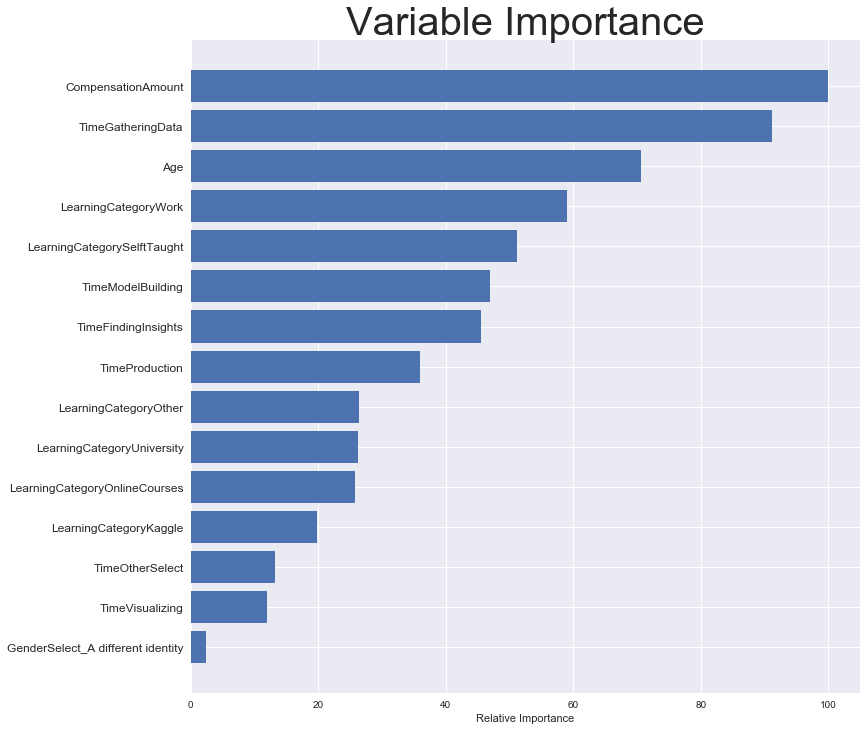

In [59]:
# Feature importance tells you for a decision tree type model which variables
# have the biggest impact on determining the predicted outcome

feature_importance = boost.feature_importances_

# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
importance = pd.DataFrame({'variable':x_train.columns, 'importance': feature_importance})
importance = importance.sort_values(by='importance', ascending = 0)
print(importance[:25])

sorted_idx = np.argsort(feature_importance[:15])

plt.clf()
pos = np.arange(sorted_idx.shape[0]) + 1
fig = plt.figure(figsize=(12,12))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, x_train[sorted_idx])
plt.tick_params(axis='y', labelsize=12)
plt.xlabel('Relative Importance')
plt.title('Variable Importance', size = 40)
plt.show()

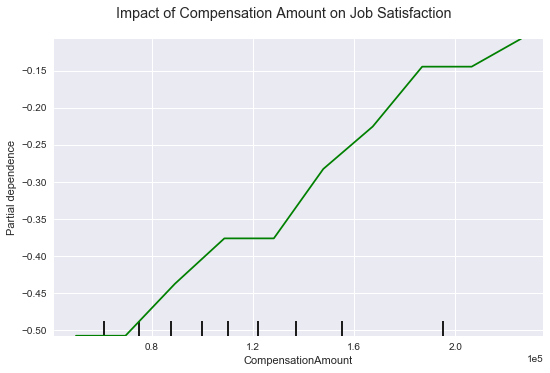

In [104]:
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.ensemble.partial_dependence import partial_dependence

plt.clf()

features = [13]
names = importance['variable']
fig, axs = plot_partial_dependence(boost, x_train, 
                                   features, feature_names = names,
                                   label = [2], grid_resolution = 10)
fig.suptitle('Impact of Compensation Amount on Job Satisfaction')
plt.subplots_adjust(top=0.9)  # tight_layout causes overlap with subtitle

plt.figure(figsize=(14,14))
plt.show()

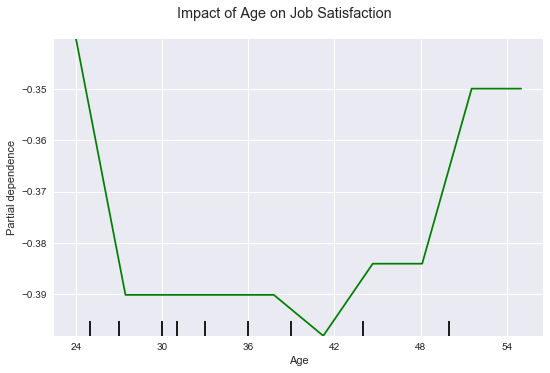

In [107]:
plt.clf()

features = [0]
names = importance['variable']
fig, axs = plot_partial_dependence(boost, x_train, 
                                   features, feature_names = names,
                                   label = [2], grid_resolution = 10)
fig.suptitle('Impact of Age on Job Satisfaction')
plt.subplots_adjust(top=0.9)  # tight_layout causes overlap with subtitle

plt.figure(figsize=(14,14))
plt.show()

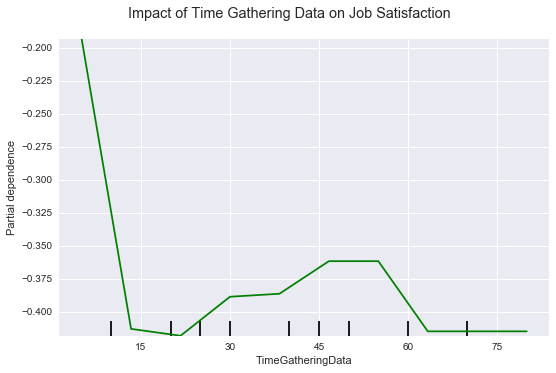

In [108]:
plt.clf()

features = [7]
names = importance['variable']
fig, axs = plot_partial_dependence(boost, x_train, 
                                   features, feature_names = names,
                                   label = [2], grid_resolution = 10)
fig.suptitle('Impact of Time Gathering Data on Job Satisfaction')
plt.subplots_adjust(top=0.9)  # tight_layout causes overlap with subtitle

plt.figure(figsize=(14,14))
plt.show()

In [141]:
categorical_col = ['GenderSelect',
       'CurrentJobTitleSelect', 'TitleFit', 'CurrentEmployerType',
        'LanguageRecommendationSelect',
       'FormalEducation', 'MajorSelect', 'Tenure', 'FirstTrainingSelect','ParentsEducation',
       'EmployerIndustry', 'EmployerSize', 'EmployerSizeChange',
       'EmployerMLTime', 'EmployerSearchMethod', 'UniversityImportance',
       'JobFunctionSelect', 'WorkDataTypeSelect', 'WorkProductionFrequency',
       'WorkDatasetSize','AlgorithmUnderstandingLevel', 'WorkDataVisualizations',
       'WorkInternalVsExternalTools', 'WorkMLTeamSeatSelect', 'RemoteWork',
       'SalaryChange']
numerical_col = ['Age', 'LearningCategorySelftTaught', 'LearningCategoryOnlineCourses',
       'LearningCategoryWork', 'LearningCategoryUniversity',
       'LearningCategoryKaggle', 'LearningCategoryOther', 'TimeGatheringData', 'TimeModelBuilding',
       'TimeProduction', 'TimeVisualizing', 'TimeFindingInsights',
       'TimeOtherSelect', 'JobSatisfaction']
      
df_cat = pd.get_dummies(df_clean[categorical_col], columns = categorical_col)
df_c_final = df_clean[numerical_col].join(df_cat)

#Impute using the median
df_c_final = df_c_final.fillna(df_c_final.median())

# For predictive modeling, always need train-test split to show performance on holdout data
# We use the train_test_split function from scikit-learn to create training data of 70%, 
# and will leave the remaining 30% for model evaluation only

x_train, x_test, y_train, y_test = train_test_split(df_c_final,df_clean['CompensationAmount'].astype(int), 
                                                    train_size = 0.7, test_size = 0.3, random_state = 1)

In [142]:
#Gradient Boosting trees
#Tune depth
tree_mse = []
tree_depth = []

for depth in range(1,4):
        boost = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1,
                                            max_depth=depth, random_state=0,
                                            min_samples_leaf = 4, subsample = 0.7,
                                            max_features = 0.7)
        tree_mse.append(-cross_val_score(boost, x_train, y_train, cv=10, 
                                         scoring = 'neg_mean_absolute_error').mean())
        tree_depth.append(depth)

    
# best k
print('Optimal MSE: ' + str(min(tree_mse)))
print('Optimal tree depth: ' + str(tree_depth[tree_mse.index(min(tree_mse))]))

Optimal MSE: 32494.389441
Optimal tree depth: 2


In [145]:
boost = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1,
                                    max_depth=2, random_state=0,
                                    min_samples_leaf = 4, subsample = 0.7,
                                    max_features = 0.7)

boost.fit(x_train,y_train)
print('Gradient boosting tree:', mean_squared_error(y_test, boost.predict(x_test)))

Gradient boosting tree: 2669690051.87


     importance                                           variable
0    100.000000                                                Age
1     37.037037                        LearningCategorySelftTaught
138   29.629630                        EmployerIndustry_Technology
44    29.629630  CurrentEmployerType_Employed by college or uni...
21    29.629630                 CurrentJobTitleSelect_Data Analyst
27    25.925926                        CurrentJobTitleSelect_Other
130   25.925926                    EmployerIndustry_Internet-based
126   25.925926                         EmployerIndustry_Financial
107   22.222222                          Tenure_More than 10 years
8     22.222222                                  TimeModelBuilding
258   22.222222             SalaryChange_Has increased 20% or more
194   18.518519  WorkDataTypeSelect_Image data,Video data,Text ...
39    18.518519  CurrentEmployerType_Employed by a company that...
158   18.518519                          EmployerMLTime_Don't 

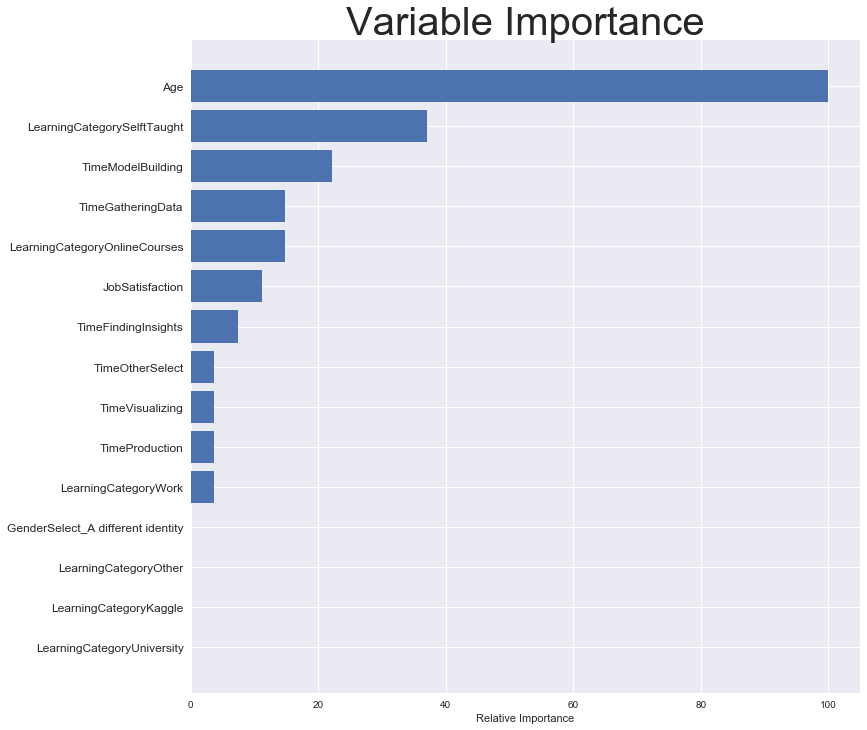

In [144]:
# Feature importance tells you for a decision tree type model which variables
# have the biggest impact on determining the predicted outcome

feature_importance = boost.feature_importances_

# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
importance = pd.DataFrame({'variable':x_train.columns, 'importance': feature_importance})
importance = importance.sort_values(by='importance', ascending = 0)
print(importance[:25])

sorted_idx = np.argsort(feature_importance[:15])

plt.clf()
pos = np.arange(sorted_idx.shape[0]) + 1
fig = plt.figure(figsize=(12,12))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, x_train[sorted_idx])
plt.tick_params(axis='y', labelsize=12)
plt.xlabel('Relative Importance')
plt.title('Variable Importance', size = 40)
plt.show()

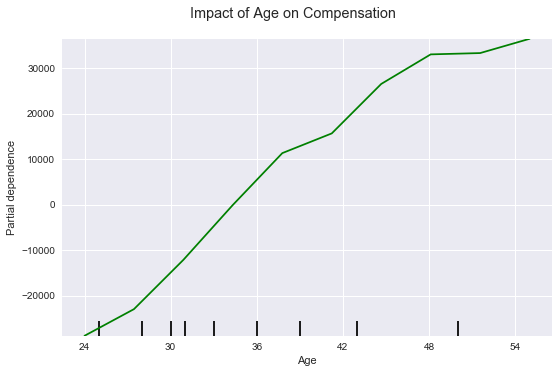

In [146]:
plt.clf()

features = [0]
names = importance['variable']
fig, axs = plot_partial_dependence(boost, x_train, 
                                   features, feature_names = names
                                   , grid_resolution = 10)
fig.suptitle('Impact of Age on Compensation')
plt.subplots_adjust(top=0.9)  # tight_layout causes overlap with subtitle

plt.figure(figsize=(14,14))
plt.show()